# Introduction

Author: Alan Lorenzetti    

Date: 02/21/2025    

This script will preprocess and analyze 3'/5' ratios for TAF1 exons data obtained using RT-qPCR 

# Setting up

In [1]:
# 20250221 alorenzetti

# description ####
# This script will preprocess and
# analyze 3'/5' ratios for TAF1 exons
# data obtained using RT-qPCR 

# setting up ####
# loading libs
packs = c(
 "tidyverse",
 "ggpubr",
 "ggthemes"
)

lapply(packs, require, character.only = TRUE)

# setting theme
theme_set(theme_bw())

# setting up working directory
if(!dir.exists("../_m")) dir.create("../_m")
setwd("../_m")

# setting up number of threads
threads=2

Loading required package: tidyverse



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: ggpubr



Loading required package: ggthemes



[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

# Getting started

In [2]:
# alorenzetti 20250221
# description ####
# this script will analyze
# RT-qPCR data for the gene
# expression of TAF1 3'/5' ratio

# getting started ####
# reading and transforming data
df = read_csv(file = "rt-qpcr35_all.csv") %>% 
  filter(Genotype != "nonedit") %>% 
  mutate(across(.cols = where(is.character),
                .fns = ~ str_replace_all(string = .x, pattern = " ", replacement = "_"))) %>% 
  mutate(`Target Name` = str_replace(string = `Target Name`, pattern = "'", replacement = "")) %>% 
  mutate(sample_id = paste0(Line, "__", `Sample Name`)) %>% 
  mutate(Day_of_Maturation = case_when(str_detect(string = `Sample Name`, "iPSC") ~ "iPSC",
                                       str_detect(string = `Sample Name`, "d30") ~ "d30",
                                       str_detect(string = `Sample Name`, "d60") ~ "d60",
                                       str_detect(string = `Sample Name`, "d90") ~ "d90",
                                       str_detect(string = `Sample Name`, "d120") ~ "d120",
                                       TRUE ~ NA_character_)) %>% 
  group_by(sample_id, `Target Name`) %>% 
  mutate(sample_id = paste0(sample_id, "__", row_number())) %>% 
  ungroup()

Rows: 297 Columns: 5


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Line, Sample Name, Genotype, Target Name
dbl (1): CT



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# some of the cts for samples are too low
mad_ct_gapdh = df %>% 
  filter(`Target Name` == "GAPDH") %>% 
  pull(CT) %>% 
  mad()

median_ct_gapdh = df %>% 
  filter(`Target Name` == "GAPDH") %>% 
  pull(CT) %>% 
  median()

max_allowed_ct_gapdh = median_ct_gapdh + (1*mad_ct_gapdh)
# max_allowed_ct_gapdh = 50

allowed_samples = df %>% 
  filter(`Target Name` == "GAPDH") %>%
  filter(CT < max_allowed_ct_gapdh) %>% 
  pull(sample_id) %>%
  unique()

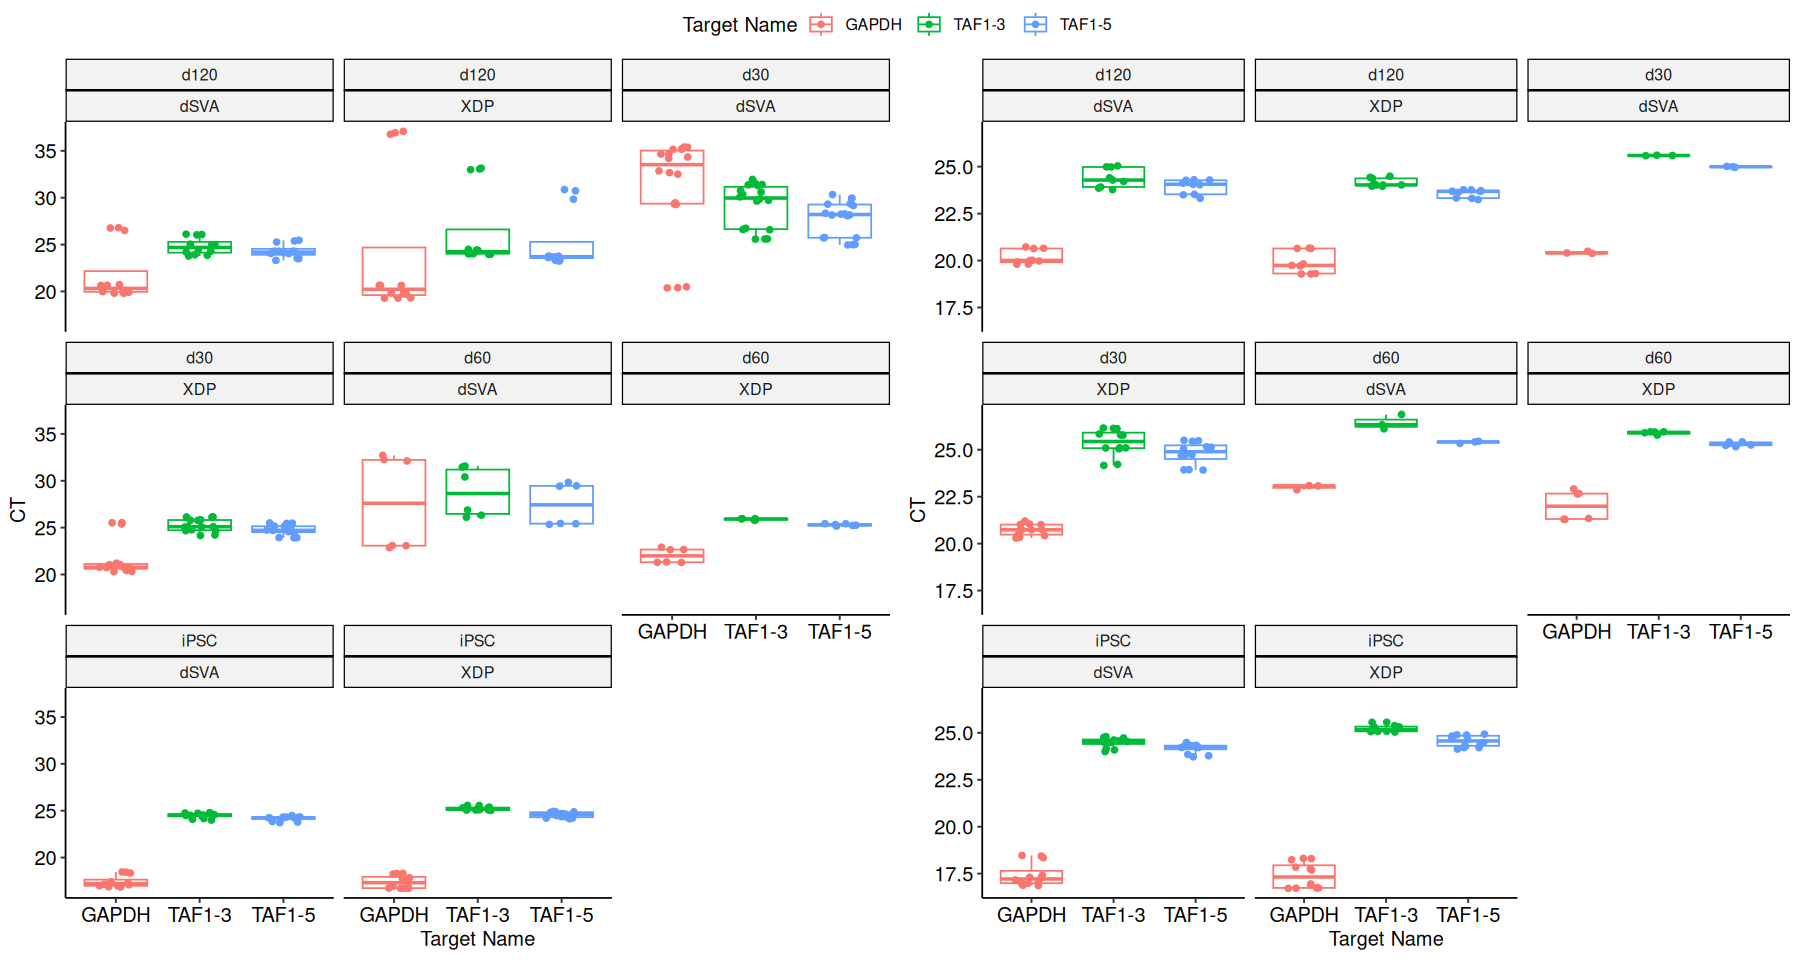

In [4]:
# quality control ####
# no ct filter vs ct filter
options(repr.plot.height = 8, repr.plot.width = 15)
ggarrange(plotlist = list(
  df %>% 
    ggplot(aes(y = CT, x = `Target Name`, color = `Target Name`)) +
    geom_boxplot(outlier.shape = NA) +
    geom_jitter(width = 0.2) +
    facet_wrap(Day_of_Maturation ~ Genotype) +
    theme_pubr()
  ,
  df %>% 
    filter(sample_id %in% allowed_samples) %>% 
    ggplot(aes(y = CT, x = `Target Name`, color = `Target Name`)) +
    geom_boxplot(outlier.shape = NA) +
    geom_jitter(width = 0.2) +
    facet_wrap(Day_of_Maturation ~ Genotype) +
    theme_pubr()#+
  # geom_line(aes(group = sample_id)) 
),
common.legend = T)

In [5]:
df35 = df %>% 
  # filter(`Target Name` != "GAPDH") %>% 
  pivot_wider(names_from = `Target Name`, values_from = "CT") %>% 
  mutate(deltaCT = `TAF1-3` - `TAF1-5`) %>% 
  mutate(foldChange = 2^-deltaCT) %>% 
  mutate(group_d_line = paste0(Line, "__", Day_of_Maturation))

df35$Day_of_Maturation = factor(df35$Day_of_Maturation, levels = c("iPSC", "d30", "d60", "d120"))
df35$Genotype = factor(df35$Genotype, levels = c("XDP", "dSVA"))

complete_pairs = df35 %>%
  filter(sample_id %in% allowed_samples) %>% 
  group_by(group_d_line, Genotype) %>%
  summarise(n = n()) %>% 
  pivot_wider(names_from = Genotype, values_from = n) %>% 
  filter(!is.na(dSVA)) %>% 
  ungroup() %>% 
  pull(group_d_line)

`summarise()` has grouped output by 'group_d_line'. You can override using the
`.groups` argument.


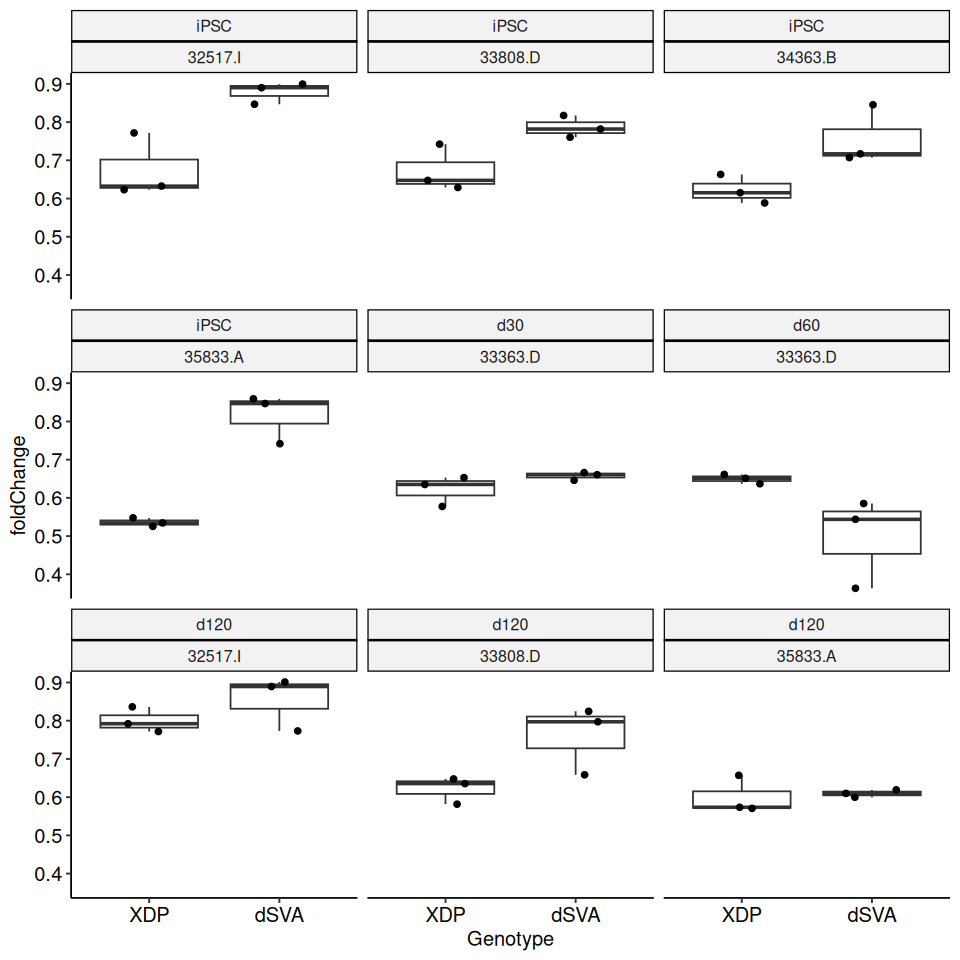

In [6]:
options(repr.plot.height = 8, repr.plot.width = 8)
df35 %>%
  filter(sample_id %in% allowed_samples) %>% 
  filter(group_d_line %in% complete_pairs) %>% 
  ggplot(aes(y = foldChange, x = Genotype)) +
  geom_boxplot(outlier.shape = NA) +
  geom_jitter(width = 0.2) +
  facet_wrap(Day_of_Maturation ~ Line) +
  theme_pubr()

In [7]:
# df35 %>% 
#   filter(sample_id %in% allowed_samples) %>% 
#   filter(group_d_line %in% complete_pairs) %>% 
#   ggplot(aes(y = log2(foldChange), x = GAPDH, shape = Genotype, color = Day_of_Maturation)) +
#   geom_point() +
#   theme_pubr()

In [8]:
#####################################################################################################################
#####################################################################################################################
# trying different approaches ####
# linear models
# normalizing fold change
avg_xdp_fc = df35 %>%
  filter(sample_id %in% allowed_samples) %>% 
  filter(group_d_line %in% complete_pairs) %>% 
  filter(Genotype == "XDP") %>%
  pull(foldChange) %>%
  mean()

data = df35 %>% 
  filter(sample_id %in% allowed_samples) %>% 
  filter(group_d_line %in% complete_pairs) %>% 
  mutate(normFoldChange = foldChange / avg_xdp_fc)

data$Line = as.factor(data$Line)
data$Day_of_Maturation = as.factor(data$Day_of_Maturation)

# iPSC
data_iPSC = subset(data, Day_of_Maturation == "iPSC")
# model_iPSC = lm(normFoldChange ~ Genotype + Line, data = data_iPSC)
# summary(model_iPSC)

# can't use a linear model for these, as there are
# missing levels
# # d30
data_d30 = subset(data, Day_of_Maturation == "d30")
# model_d30 = lm(normFoldChange ~ Line, data = data_d30)
# summary(model_d30)
# 
# # d60
data_d60 = subset(data, Day_of_Maturation == "d60")
# model_d60 = lm(normFoldChange ~ Line, data = data_d60)
# summary(model_d60)

# d120
data_d120 = subset(data, Day_of_Maturation == "d120")
# model_d120 = lm(normFoldChange ~ Genotype + Line, data = data_d120)
# summary(model_d120)

# iPSC and d120
data_iPSC_d120 = subset(data, Day_of_Maturation == "iPSC" | Day_of_Maturation == "d120")
# model_iPSC_d120 = lm(normFoldChange ~ Genotype + Line + Day_of_Maturation + GAPDH, data = data_iPSC_d120)
# summary(model_iPSC_d120)

# all
# model_all = lm(normFoldChange ~ Genotype + Line + Day_of_Maturation + GAPDH, data = data)
# summary(model_all)

In [9]:
#####################################################################################################################
#####################################################################################################################
# paired t-tests using the average of technical replicates
# for each of the time points
# iPSC
iPSC_xdp_dsva = data_iPSC %>% 
  group_by(Line, Genotype, Day_of_Maturation) %>% 
  summarise(average_foldChange = mean(foldChange)) %>% 
  ungroup() %>% 
  mutate(xdp_average_foldchange = (data_iPSC %>% filter(Genotype == "XDP") %>% pull(foldChange) %>% mean())) %>% 
  mutate(normFoldChange = average_foldChange/xdp_average_foldchange) %>% 
  select(Line, Genotype, normFoldChange) %>% 
  pivot_wider(names_from = "Genotype", values_from = "normFoldChange")

t.test(x = iPSC_xdp_dsva$dSVA, y = iPSC_xdp_dsva$XDP, var.equal = F, paired = T)

iPSC_plot = iPSC_xdp_dsva %>% 
  pivot_longer(cols = any_of(x = c("XDP", "dSVA")),
               names_to = "Genotype", values_to = "normFoldChange") %>% 
  mutate(Genotype = factor(Genotype, levels = c("XDP", "dSVA"))) %>% 
  ggplot(aes(x = Genotype, y = normFoldChange, fill = Genotype)) +
  stat_summary(fun = mean, geom = "bar", color = "black") +
  stat_summary(fun.data = mean_se, geom = "errorbar", width = 0.2, color = "black") +
  stat_compare_means(comparisons = list(c("XDP", "dSVA")), paired = T,
                     method.args = list(var.equal = F, alternative = "two.sided"),
                     method = "t.test", ref.group = "XDP") +
  scale_fill_manual(values = c("XDP" = "#d55e01", "dSVA" = "#ededed")) +
  theme_pubr() +
  xlab(label = NULL) +
  ylab(label = "Normalized fold change") +
  theme(legend.position = "none") +
  ylim(c(0,1.5))

`summarise()` has grouped output by 'Line', 'Genotype'. You can override using
the `.groups` argument.



	Paired t-test

data:  iPSC_xdp_dsva$dSVA and iPSC_xdp_dsva$XDP
t = 4.8544, df = 3, p-value = 0.01669
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 0.1004608 0.4829001
sample estimates:
mean difference 
      0.2916804 


In [10]:
# d30
d30_xdp_dsva = data_d30 %>% 
  mutate(xdp_average_foldchange = (data_d30 %>% filter(Genotype == "XDP") %>% pull(foldChange) %>% mean())) %>% 
  mutate(normFoldChange = foldChange/xdp_average_foldchange) %>% 
  select(Line, Genotype, normFoldChange) %>% 
  group_by(Line, Genotype) %>%
  mutate(Line_ID = paste0(Line, "_", row_number())) %>% 
  summarise(normFoldChange = mean(normFoldChange)) %>%
  ungroup() %>% 
  pivot_wider(names_from = "Genotype", values_from = "normFoldChange")

# t.test(x = d30_xdp_dsva$dSVA, y = d30_xdp_dsva$XDP, var.equal = F)

d30_plot = d30_xdp_dsva %>% 
  pivot_longer(cols = any_of(x = c("XDP", "dSVA")),
               names_to = "Genotype", values_to = "normFoldChange") %>% 
  mutate(Genotype = factor(Genotype, levels = c("XDP", "dSVA"))) %>% 
  ggplot(aes(x = Genotype, y = normFoldChange, fill = Genotype)) +
  stat_summary(fun = mean, geom = "bar", color = "black") +
  stat_summary(fun.data = mean_se, geom = "errorbar", width = 0.2, color = "black") +
  stat_compare_means(comparisons = list(c("XDP", "dSVA")),
                     method.args = list(var.equal = F, alternative = "two.sided"),
                     method = "t.test", ref.group = "XDP") +
  scale_fill_manual(values = c("XDP" = "#d55e01", "dSVA" = "#ededed")) +
  theme_pubr() +
  xlab(label = NULL) +
  ylab(label = NULL) +
  theme(legend.position = "none") +
  ylim(c(0,1.5))

`summarise()` has grouped output by 'Line'. You can override using the
`.groups` argument.


In [11]:
# d60
d60_xdp_dsva = data_d60 %>% 
  mutate(xdp_average_foldchange = (data_d60 %>% filter(Genotype == "XDP") %>% pull(foldChange) %>% mean())) %>% 
  mutate(normFoldChange = foldChange/xdp_average_foldchange) %>% 
  select(Line, Genotype, normFoldChange) %>% 
  group_by(Line, Genotype) %>%
  mutate(Line_ID = paste0(Line, "_", row_number())) %>% 
  summarise(normFoldChange = mean(normFoldChange)) %>%
  ungroup() %>% 
  pivot_wider(names_from = "Genotype", values_from = "normFoldChange")

# t.test(x = d60_xdp_dsva$dSVA, y = d60_xdp_dsva$XDP, var.equal = F)

d60_plot = d60_xdp_dsva %>% 
  pivot_longer(cols = any_of(x = c("XDP", "dSVA")),
               names_to = "Genotype", values_to = "normFoldChange") %>% 
  mutate(Genotype = factor(Genotype, levels = c("XDP", "dSVA"))) %>% 
  ggplot(aes(x = Genotype, y = normFoldChange, fill = Genotype)) +
  stat_summary(fun = mean, geom = "bar", color = "black") +
  stat_summary(fun.data = mean_se, geom = "errorbar", width = 0.2, color = "black") +
  stat_compare_means(comparisons = list(c("XDP", "dSVA")),
                     method.args = list(var.equal = F, alternative = "two.sided"),
                     method = "t.test", ref.group = "XDP") +
  scale_fill_manual(values = c("XDP" = "#d55e01", "dSVA" = "#ededed")) +
  theme_pubr() +
  xlab(label = NULL) +
  ylab(label = NULL) +
  theme(legend.position = "none") +
  ylim(c(0,1.5))

`summarise()` has grouped output by 'Line'. You can override using the
`.groups` argument.


In [12]:
## d120
d120_xdp_dsva = data_d120 %>% 
  group_by(Line, Genotype, Day_of_Maturation) %>% 
  summarise(average_foldChange = mean(foldChange)) %>% 
  ungroup() %>% 
  mutate(xdp_average_foldchange = (data_d120 %>% filter(Genotype == "XDP") %>% pull(foldChange) %>% mean())) %>% 
  mutate(normFoldChange = average_foldChange/xdp_average_foldchange) %>% 
  select(Line, Genotype, normFoldChange) %>% 
  pivot_wider(names_from = "Genotype", values_from = "normFoldChange")

t.test(x = d120_xdp_dsva$dSVA, y = d120_xdp_dsva$XDP, var.equal = F, paired = T)

d120_plot = d120_xdp_dsva %>% 
  pivot_longer(cols = any_of(x = c("XDP", "dSVA")),
               names_to = "Genotype", values_to = "normFoldChange") %>% 
  mutate(Genotype = factor(Genotype, levels = c("XDP", "dSVA"))) %>% 
  ggplot(aes(x = Genotype, y = normFoldChange, fill = Genotype)) +
  stat_summary(fun = mean, geom = "bar", color = "black") +
  stat_summary(fun.data = mean_se, geom = "errorbar", width = 0.2, color = "black") +
  stat_compare_means(comparisons = list(c("XDP", "dSVA")), paired = T,
                     method.args = list(var.equal = F, alternative = "two.sided"),
                     method = "t.test", ref.group = "XDP") +
  scale_fill_manual(values = c("XDP" = "#d55e01", "dSVA" = "#ededed")) +
  theme_pubr() +
  xlab(label = NULL) +
  ylab(label = NULL) +
  theme(legend.position = "none") +
  ylim(c(0,1.5))

`summarise()` has grouped output by 'Line', 'Genotype'. You can override using
the `.groups` argument.



	Paired t-test

data:  d120_xdp_dsva$dSVA and d120_xdp_dsva$XDP
t = 1.7779, df = 2, p-value = 0.2174
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -0.1420542  0.3421230
sample estimates:
mean difference 
      0.1000344 


Warning message:
“Computation failed in `stat_signif()`.
Caused by error in `t.test.default()`:
! not enough 'x' observations”


Warning message:
“Computation failed in `stat_signif()`.
Caused by error in `t.test.default()`:
! not enough 'x' observations”


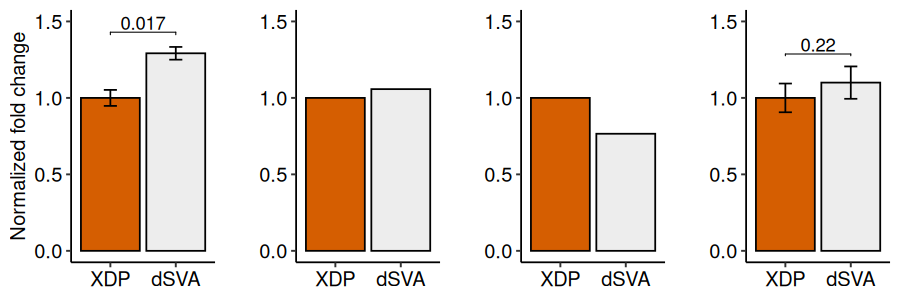

In [13]:
options(repr.plot.height = 2.5, repr.plot.width = 7.5)
arranged_plot = ggarrange(plotlist = list(iPSC_plot,
                                          d30_plot,
                                          d60_plot,
                                          d120_plot),
                          nrow = 1, align = "v")
arranged_plot

ggsave(filename = "35_ratio_norm_within_day__filtered.pdf", plot = arranged_plot, width = 7.5, height = 2.5)

In [14]:
# in addition, analyzing d30 and d60 altogether
d30_d60_xdp_dsva = bind_rows(data_d30, data_d60) %>% 
  group_by(Line, Genotype, Day_of_Maturation) %>% 
  summarise(average_foldChange = mean(foldChange)) %>% 
  ungroup() %>% 
  mutate(xdp_average_foldchange = (bind_rows(data_d30,  data_d60) %>% filter(Genotype == "XDP") %>% pull(foldChange) %>% mean())) %>% 
  mutate(normFoldChange = average_foldChange/xdp_average_foldchange) %>% 
  select(Line, Day_of_Maturation, Genotype, normFoldChange) %>% 
  pivot_wider(names_from = "Genotype", values_from = "normFoldChange")

`summarise()` has grouped output by 'Line', 'Genotype'. You can override using
the `.groups` argument.


In [15]:
t.test(x = d30_d60_xdp_dsva$dSVA, y = d30_d60_xdp_dsva$XDP, var.equal = F, paired = T)


	Paired t-test

data:  d30_d60_xdp_dsva$dSVA and d30_d60_xdp_dsva$XDP
t = -0.6204, df = 1, p-value = 0.6465
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -1.970151  1.786717
sample estimates:
mean difference 
    -0.09171683 


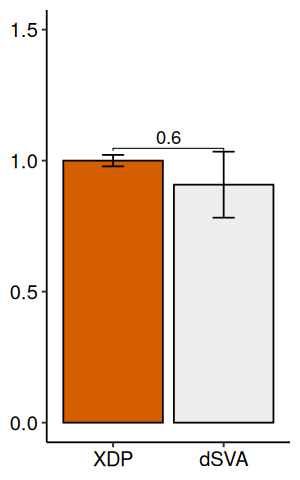

In [16]:
options(repr.plot.height = 4, repr.plot.width = 2.5)
d30_d60_plot = d30_d60_xdp_dsva %>% 
  pivot_longer(cols = any_of(x = c("XDP", "dSVA")),
               names_to = "Genotype", values_to = "normFoldChange") %>% 
  mutate(Genotype = factor(Genotype, levels = c("XDP", "dSVA"))) %>% 
  ggplot(aes(x = Genotype, y = normFoldChange, fill = Genotype)) +
  stat_summary(fun = mean, geom = "bar", color = "black") +
  stat_summary(fun.data = mean_se, geom = "errorbar", width = 0.2, color = "black") +
  stat_compare_means(comparisons = list(c("XDP", "dSVA")),
                     method.args = list(var.equal = F, alternative = "two.sided"),
                     method = "t.test", ref.group = "XDP") +
  scale_fill_manual(values = c("XDP" = "#d55e01", "dSVA" = "#ededed")) +
  theme_pubr() +
  xlab(label = NULL) +
  ylab(label = NULL) +
  theme(legend.position = "none") +
  ylim(c(0,1.5))
d30_d60_plot

# Session Info

In [17]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: x86_64-pc-linux-gnu
Running under: Arch Linux

Matrix products: default
BLAS:   /usr/lib/libblas.so.3.12.0 
LAPACK: /usr/lib/liblapack.so.3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: EST
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggthemes_5.1.0  ggpubr_0.6.0    lubridate_1.9.4 forcats_1.0.0  
 [5] stringr_1.5.1   dplyr_1.1.4     purrr_1.0.2     readr_2.1.5    
 [9] tidyr_1.3.1     tibble_3.2.1    ggplot2_3.5.1   tidyverse_2.0.0

loaded via a namespace (and not attached):
 [1] generics_0.1.3    rstatix_